<a href="https://colab.research.google.com/github/gauwuhar/final_project_hybrid_brain/blob/main/IEEEbrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.cluster import AgglomerativeClustering
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

In [ ]:
# === Глобальные настройки ===
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']  # категории опухолей
DATASET_PATH = path  # обновите путь к вашему датасету




In [ ]:
# === Предобработка: кластеризация + HOG ===
def preprocess_and_cluster(image_path):
    image = imread(image_path)
    image = resize(image, IMAGE_SIZE)
    gray = rgb2gray(image)

    # 1. HOG
    hog_features, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

    # 2. Кластеризация (иерархическая)
    reshaped = gray.reshape(-1, 1)
    clustering = AgglomerativeClustering(n_clusters=2).fit(reshaped)
    clustered = clustering.labels_.reshape(IMAGE_SIZE)

    return np.expand_dims(clustered, axis=-1)  # grayscale + кластеризация результат


In [ ]:
# === Предобработка: кластеризация + HOG ===
def preprocess_and_cluster(image_path):
    image = imread(image_path)
    image = resize(image, IMAGE_SIZE)

    # Check if the image is already grayscale
    if len(image.shape) == 2 or image.shape[2] == 1:  # check the number of dimensions or channels
        gray = image  # If grayscale, assign directly
    else:
        gray = rgb2gray(image) # if RGB, convert to grayscale

    # 1. HOG
    hog_features, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

    # 2. Кластеризация (иерархическая)
    reshaped = gray.reshape(-1, 1)
    clustering = AgglomerativeClustering(n_clusters=2).fit(reshaped)
    clustered = clustering.labels_.reshape(IMAGE_SIZE)

    return np.expand_dims(clustered, axis=-1)  # grayscale + кластеризация результат

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize  # Для изменения размера изображений
from sklearn.preprocessing import LabelEncoder
import time

# Убедитесь, что DATASET_PATH указывает на правильный путь
DATASET_PATH = path  # Убедитесь, что эта переменная указывает на правильный путь

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']  # категории опухолей

X = []
y = []

# Функция для предварительной обработки и уменьшения размера изображения
def preprocess_and_cluster(image_path):
    # Загружаем изображение
    image = imread(image_path, as_gray=True)  # Читаем как изображение в оттенках серого
    # Изменяем размер изображения для уменьшения нагрузки
    image_resized = resize(image, (128, 128), anti_aliasing=True)  # Пример уменьшения до 128x128
    return image_resized

# Обрабатываем изображения из папки Training
start_time = time.time()  # Начало отсчета времени
for class_name in CLASSES:
    class_path = os.path.join(DATASET_PATH, 'Training', class_name)  # Путь к папке с изображениями
    if not os.path.exists(class_path):
        print(f"Папка {class_path} не существует!")
        continue  # Пропустим, если папка не существует
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Преобразуем изображение
        processed_image = preprocess_and_cluster(image_path)

        X.append(processed_image)
        y.append(class_name)

end_time = time.time()  # Конец отсчета времени
print(f"Время обработки всех изображений: {end_time - start_time:.2f} секунд")

# Преобразуем X и y в массивы numpy
X = np.array(X)
y = np.array(y)

# Преобразуем метки в числовой формат
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающего набора: {X_train.shape}")
print(f"Размер тестового набора: {X_test.shape}")


Время обработки всех изображений: 63.68 секунд
Размер обучающего набора: (4569, 128, 128)
Размер тестового набора: (1143, 128, 128)


In [ ]:
# === Модель CNN ===
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(CLASSES), activation='softmax')  # количество классов: 4
])

# Убедитесь, что модель компилируется только один раз
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=len(CLASSES))
y_test = to_categorical(y_test, num_classes=len(CLASSES))

# === Обучение ===
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=BATCH_SIZE)

# === Оценка ===
model.evaluate(X_test, y_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6136 - loss: 0.8921 - val_accuracy: 0.8373 - val_loss: 0.4319
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8447 - loss: 0.3850 - val_accuracy: 0.8539 - val_loss: 0.3406
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8906 - loss: 0.2695 - val_accuracy: 0.9108 - val_loss: 0.2495
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9378 - loss: 0.1639 - val_accuracy: 0.9143 - val_loss: 0.2515
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9584 - loss: 0.1155 - val_accuracy: 0.9379 - val_loss: 0.2177
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9715 - loss: 0.0839 - val_accuracy: 0.9221 - val_loss: 0.2817
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9825 - loss: 0.0575 - val_accuracy: 0.9353 - val_loss: 0.2147
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9856 - loss: 0.0459 - val_acc

[0.3805338442325592, 0.9282589554786682]

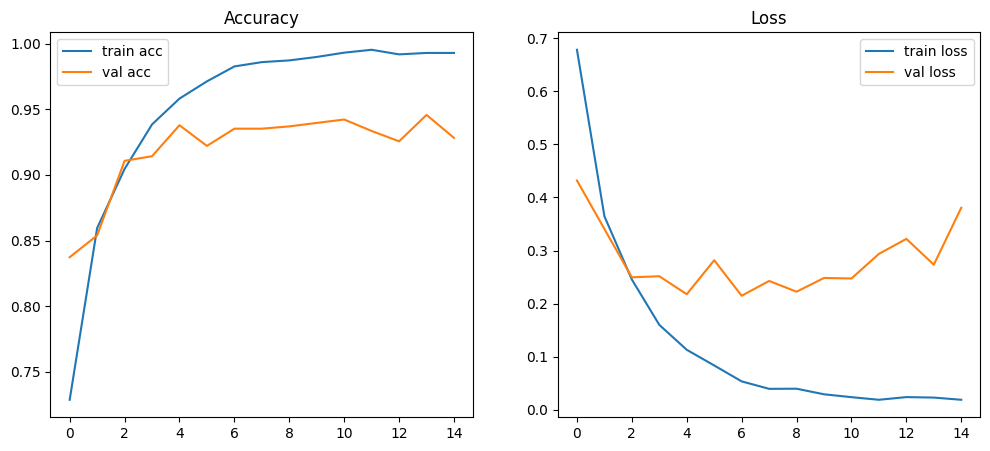

In [ ]:

# === Визуализация результатов ===
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='train acc')
    plt.plot(hist.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)

In [ ]:
# === Обычная модель CNN (без кластеризации и HOG) ===
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(CLASSES), activation='softmax')  # количество классов: 4
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучаем обычную модель CNN
start_time_cnn = time.time()
history_cnn = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=BATCH_SIZE)
end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn

# Оценка модели CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5960 - loss: 0.9658 - val_accuracy: 0.8373 - val_loss: 0.4563
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8397 - loss: 0.4017 - val_accuracy: 0.8775 - val_loss: 0.3353
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9039 - loss: 0.2643 - val_accuracy: 0.9125 - val_loss: 0.2419
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9474 - loss: 0.1576 - val_accuracy: 0.9108 - val_loss: 0.2626
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9608 - loss: 0.1201 - val_accuracy: 0.9151 - val_loss: 0.2466
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9687 - loss: 0.0904 - val_accuracy: 0.9318 - val_loss: 0.2153
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9773 - loss: 0.0658 - val_accuracy: 0.9318 - val_loss: 0.2101
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9888 - loss: 0.0446 - val_accu

In [ ]:

# === Гибридная модель (с кластеризацией и HOG) ===
hybrid_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(CLASSES), activation='softmax')  # количество классов: 4
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучаем гибридную модель
start_time_hybrid = time.time()
history_hybrid = hybrid_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=BATCH_SIZE)
end_time_hybrid = time.time()
hybrid_training_time = end_time_hybrid - start_time_hybrid

# Оценка гибридной модели
hybrid_loss, hybrid_accuracy = hybrid_model.evaluate(X_test, y_test)



Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5347 - loss: 1.1175 - val_accuracy: 0.8084 - val_loss: 0.4551
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8175 - loss: 0.4801 - val_accuracy: 0.8705 - val_loss: 0.3256
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8931 - loss: 0.2867 - val_accuracy: 0.8828 - val_loss: 0.3063
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9214 - loss: 0.2178 - val_accuracy: 0.9309 - val_loss: 0.2213
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9466 - loss: 0.1493 - val_accuracy: 0.9291 - val_loss: 0.2028
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9645 - loss: 0.1114 - val_accuracy: 0.9361 - val_loss: 0.1878
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9759 - loss: 0.0699 - val_accuracy: 0.9501 - val_loss: 0.1831
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9778 - loss: 0.0706 - val_accu

In [ ]:

# === Сравнение результатов ===
print(f"Обычная модель CNN:")
print(f"Точность: {cnn_accuracy:.4f}, Потери: {cnn_loss:.4f}")
print(f"Время обучения: {cnn_training_time:.2f} секунд")

print(f"\nГибридная модель (с кластеризацией и HOG):")
print(f"Точность: {hybrid_accuracy:.4f}, Потери: {hybrid_loss:.4f}")
print(f"Время обучения: {hybrid_training_time:.2f} секунд")

# Сравнение
accuracy_diff = hybrid_accuracy - cnn_accuracy
loss_diff = cnn_loss - hybrid_loss
time_diff = hybrid_training_time - cnn_training_time

print(f"\nРазница в точности: {accuracy_diff:.4f}")
print(f"Разница в потерях: {loss_diff:.4f}")
print(f"Разница во времени обучения: {time_diff:.2f} секунд")

Обычная модель CNN:
Точность: 0.9361, Потери: 0.2972
Время обучения: 47.93 секунд

Гибридная модель (с кластеризацией и HOG):
Точность: 0.9475, Потери: 0.2537
Время обучения: 41.16 секунд

Разница в точности: 0.0114
Разница в потерях: 0.0435
Разница во времени обучения: -6.77 секунд


In [ ]:
# prompt: cnn-only and Hybrid results accuracy, precision, recall, f1-score, processing time in table do with actual values with entire code

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ... (your existing code) ...

# Make predictions
cnn_predictions = cnn_model.predict(X_test)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

hybrid_predictions = hybrid_model.predict(X_test)
hybrid_predicted_labels = np.argmax(hybrid_predictions, axis=1)

true_labels = np.argmax(y_test, axis=1)


def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return accuracy, precision, recall, f1

cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = calculate_metrics(true_labels, cnn_predicted_labels)
hybrid_accuracy, hybrid_precision, hybrid_recall, hybrid_f1 = calculate_metrics(true_labels, hybrid_predicted_labels)


data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Processing Time (seconds)'],
    'CNN-only': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_training_time],
    'Hybrid': [hybrid_accuracy, hybrid_precision, hybrid_recall, hybrid_f1, hybrid_training_time],
}

df = pd.DataFrame(data)
df


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


,Metric,CNN-only,Hybrid
0,Accuracy,0.936133,0.947507
1,Precision,0.938012,0.948095
2,Recall,0.936133,0.947507
3,F1-score,0.936253,0.947344
4,Processing Time (seconds),47.927586,41.158957
